In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

Будем работать с набором данных по качеству белого вина:

In [3]:
data = pd.read_csv("winequality-white.csv", sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Отделим целевой признак, разделим обучающую выборку в отношении 7:3 (пусть ```random_state=17```) и отмасштабируем данные с помощью StandardScaler:

In [5]:
y = data['quality']
X = data.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [6]:
features = []
for col in X_train.columns:
        features.append(col)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
                                        ('scaling', StandardScaler(), features)
                                       ])

In [8]:
X_train_scaled = column_transformer.fit_transform(X_train)
X_test_scaled = column_transformer.transform(X_test)

Обучим простую линейную регрессию и посчитаем MSE:

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [10]:
linreg = LinearRegression().fit(X_train_scaled, y_train)

y_pred = linreg.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = linreg.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 0.5581
Test MSE = 0.5842


Посмотрим на коэффициенты модели и отранжируем признаки по влиянию на качество вина (учтем, что большие по модулю отрицательные значения коэффициентов тоже говорят о большом влиянии):

In [11]:
linreg_coef = pd.DataFrame({'coefs': linreg.coef_})
linreg_coef.head()

,coefs
0,0.097822
1,-0.192260
2,-0.000183
3,0.538164
4,0.008127


In [12]:
importance = linreg.coef_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.09782
Feature: 1, Score: -0.19226
Feature: 2, Score: -0.00018
Feature: 3, Score: 0.53816
Feature: 4, Score: 0.00813
Feature: 5, Score: 0.04218
Feature: 6, Score: 0.01430
Feature: 7, Score: -0.66572
Feature: 8, Score: 0.15004
Feature: 9, Score: 0.06205
Feature: 10, Score: 0.12953


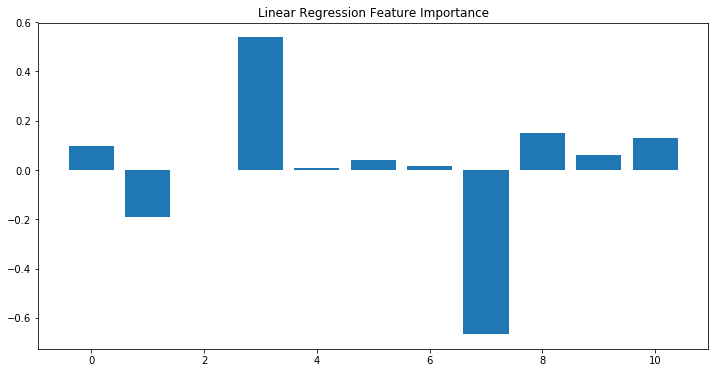

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Linear Regression Feature Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [14]:
def coefSort(model):
    tmp_list1 = []
    tmp_list2 = []
    tmp = []
    i = 0 
    j = 0
    
    for k in range(int(model.size)):
        if model['coefs'].iloc[k] > 1e-14:
            tmp_list1.append(model['coefs'].iloc[k])
        else:
            tmp_list2.append(model['coefs'].iloc[k])
    
    tmp_list1.sort(reverse=True)
    tmp_list2.sort()

    while ( i < len(tmp_list1) and j < len(tmp_list2) ):
        if tmp_list1[i] - abs(tmp_list2[j]) > 1e-14:
            tmp.append(tmp_list1[i])
            i += 1
        else:
            tmp.append(tmp_list2[j])
            j += 1
    
    while i < len(tmp_list1):
        tmp.append(tmp_list1[i])
        i += 1
    while j < len(tmp_list2):
        tmp.append(tmp_list2[j])
        j += 1
        
    return tmp

In [15]:
linreg_coef = pd.DataFrame({'LR_coef': coefSort(linreg_coef)})
linreg_coef.head()

,LR_coef
0,-0.665720
1,0.538164
2,-0.192260
3,0.150036
4,0.129533


Обучим Lasso-регрессию с небольшим коэффициентом α=0.01 регуляризации (random_state=17):

In [16]:
from sklearn.linear_model import Lasso

In [17]:
lasso = Lasso(alpha = 0.01, random_state=17).fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = lasso.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 0.5638
Test MSE = 0.5737


Было:
<br>Train MSE = 0.5581
<br>Test MSE = 0.5842

Посмотрим на коэффициенты модели и отранжируем признаки по влиянию на качество вина:

In [18]:
lasso_coef = pd.DataFrame({'coefs': lasso.coef_})
lasso_coef.head()

,coefs
0,-0.000000
1,-0.188479
2,-0.000000
3,0.256363
4,-0.002747


In [19]:
importance = lasso.coef_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.18848
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.25636
Feature: 4, Score: -0.00275
Feature: 5, Score: 0.04309
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.23549
Feature: 8, Score: 0.06728
Feature: 9, Score: 0.02972
Feature: 10, Score: 0.32243


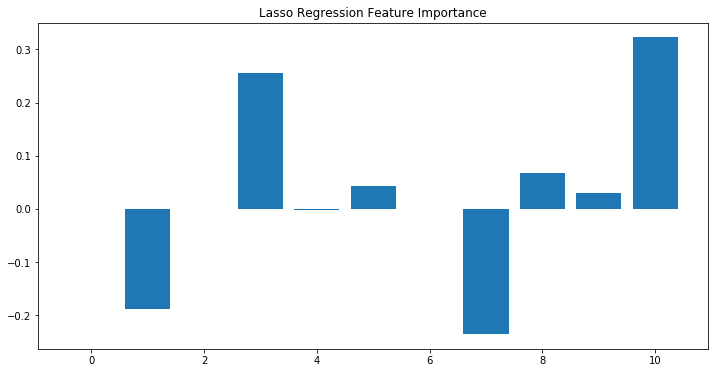

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Lasso Regression Feature Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [21]:
lasso_coef = pd.DataFrame({'Lasso_coef': coefSort(lasso_coef)})
lasso_coef.head()

,Lasso_coef
0,0.322425
1,0.256363
2,-0.235492
3,-0.188479
4,0.067277


Теперь определим лучшее значение α в процессе 5-кратной кросс-валидации (LassoCV, random_state=17):

In [22]:
from sklearn.model_selection import StratifiedKFold, KFold

import warnings
warnings.filterwarnings("ignore")

Проверим, что не имеем NaN или inf значений:

In [23]:
where_XNaNs = np.isnan(X_train_scaled)
where_yNaNs = np.isnan(y_train)
print(X_train_scaled[where_XNaNs])
print(y_train[where_yNaNs])

print()

where_Xinfs = np.isinf(X_train_scaled)
where_yinfs = np.isinf(y_train)
print(X_train_scaled[where_Xinfs])
print(y_train[where_yinfs])

[]
Series([], Name: quality, dtype: int64)

[]
Series([], Name: quality, dtype: int64)


In [24]:
print(cross_val_score(
                    LassoCV(random_state=17), 
                    X_train_scaled, 
                    y_train, 
                    cv = 5,
                    scoring='neg_mean_squared_error' \
                ).mean())

-0.5604458087395217


In [25]:
print(cross_val_score(
                    LassoCV(random_state=17), 
                    X_train_scaled, 
                    y_train, 
                    cv = 5,
                    scoring='neg_mean_squared_error' \
                ).min())

-0.630902478321585


In [26]:
print(cross_val_score(
                    LassoCV(random_state=17), 
                    X_train_scaled, 
                    y_train, 
                    cv = 5,
                    scoring='neg_mean_squared_error' \
                ).max())

-0.5027522375773936


In [27]:
alphas = np.logspace(-6, 2, 200)
skf = StratifiedKFold(n_splits=5)
lasso_cv = LassoCV(alphas=alphas, random_state=17, max_iter=5000)

for k, (train, test) in enumerate( skf.split(X_train_scaled, y_train) ):
    lasso_cv.fit(X_train_scaled[train], y_train.iloc[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(skf, lasso_cv.alpha_, lasso_cv.score(X_train_scaled[test], y_train.iloc[test]))
         )

[fold StratifiedKFold(n_splits=5, random_state=None, shuffle=False)] alpha: 0.00094, score: 0.24477
[fold StratifiedKFold(n_splits=5, random_state=None, shuffle=False)] alpha: 0.00037, score: 0.26775
[fold StratifiedKFold(n_splits=5, random_state=None, shuffle=False)] alpha: 0.00086, score: 0.33210
[fold StratifiedKFold(n_splits=5, random_state=None, shuffle=False)] alpha: 0.00137, score: 0.31348
[fold StratifiedKFold(n_splits=5, random_state=None, shuffle=False)] alpha: 0.00071, score: 0.27691


In [28]:
# The amount of penalization chosen by cross validation
lasso_cv.alpha_

0.0007149428986597577

In [29]:
k_fold = KFold(5)

for k, (train, test) in enumerate(k_fold.split(X_train_scaled, y_train)):
    lasso_cv.fit(X_train_scaled[train], y_train.iloc[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X_train_scaled[test], y_train.iloc[test]))
         )

[fold 0] alpha: 0.00094, score: 0.25215
[fold 1] alpha: 0.00059, score: 0.29442
[fold 2] alpha: 0.00104, score: 0.31137
[fold 3] alpha: 0.00125, score: 0.30345
[fold 4] alpha: 0.00086, score: 0.27846


In [30]:
# The amount of penalization chosen by cross validation
lasso_cv.alpha_

0.0008603464416684501

Посчитаем качество при лучшем α:

In [31]:
lasso = Lasso(alpha=0.0007149428986597577, random_state=17).fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = lasso.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 0.5581
Test MSE = 0.5819


Было:
<br>Train MSE = 0.5638
<br>Test MSE = 0.5737

------
------
------

Обучим случайный лес с параметрами "из коробки" (random_state=17):

In [32]:
rfr = RandomForestRegressor(random_state=17).fit(X_train_scaled, y_train)

y_pred = rfr.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = rfr.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 0.0526
Test MSE = 0.3716


In [33]:
print(cross_val_score(
                    RandomForestRegressor(random_state=17), 
                    X_train_scaled, 
                    y_train, 
                    cv = 5,
                    scoring='neg_mean_squared_error' \
                ).mean())

-0.4142003732204039


Настроим параметры min_samples_leaf и max_depth с помощью GridSearchCV и опять проверим качество модели:

In [34]:
param_grid = { 
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth': [5, 6, 7, 8, 9, 10, 15, 20]
}

In [35]:
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
CV_rfr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=17),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4, 5]})

In [36]:
CV_rfr.best_params_

{'max_depth': 20, 'min_samples_leaf': 2}

In [37]:
CV_rfr.best_score_

0.46558341899711014

In [38]:
param_grid = { 
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'max_depth': [18, 19, 20, 21, 22, 25]
}

In [39]:
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
CV_rfr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=17),
             param_grid={'max_depth': [18, 19, 20, 21, 22, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10]})

In [40]:
CV_rfr.best_params_

{'max_depth': 21, 'min_samples_leaf': 1}

In [41]:
CV_rfr.best_score_

0.4745202959887548

In [42]:
rfr = RandomForestRegressor(min_samples_leaf=1, max_depth=21, random_state=17).fit(X_train_scaled, y_train)

y_pred = rfr.predict(X_train_scaled)
print("Train MSE = %.4f" % mean_squared_error(y_train, y_pred))
y_pred = rfr.predict(X_test_scaled)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Train MSE = 0.0537
Test MSE = 0.3726


Было:
<br>Train MSE = 0.0526
<br>Test MSE = 0.3716

In [43]:
print(cross_val_score(
                    RandomForestRegressor(min_samples_leaf=1, max_depth=21, random_state=17), 
                    X_train_scaled, 
                    y_train, 
                    cv = 5,
                    scoring='neg_mean_squared_error' \
                ).mean())

-0.41302942684787947


Было:
<br>-0.4142003732204039

Оценим важность признаков с помощью случайного леса:

In [44]:
importance = rfr.feature_importances_
importance

array([0.06183092, 0.12565739, 0.05841622, 0.07146442, 0.06349754,
       0.11597565, 0.0679813 , 0.05707124, 0.07201366, 0.05843547,
       0.24765619])

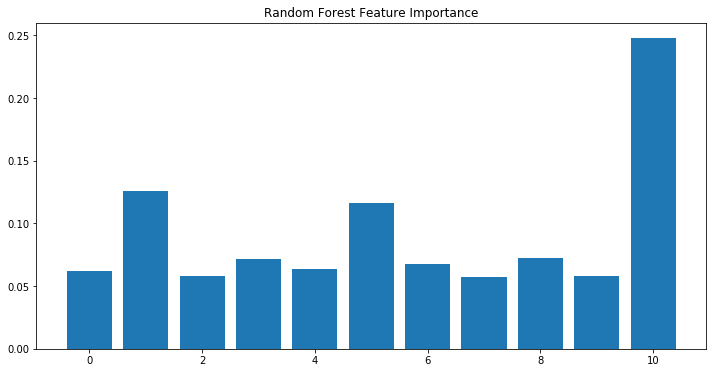

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Random Forest Feature Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.show()